# Kickstarter Projects Analysis

## Importing Data

In [0]:
import os, math, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [200]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

dataset_name = 'ks-projects-201801.csv'

from google.colab import files
import os.path

if not os.path.isfile(dataset_name):
  print('upload kaggle.json file for Kaggle CLI authentication')
  files.upload()
else:
  print('skipping kaggle.json upload - already present')

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kemical/kickstarter-projects > /dev/null

from zipfile import ZipFile
with ZipFile('kickstarter-projects.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
  zipObj.extractall()
  zipObj.close()

skipping kaggle.json upload - already present


In [201]:
df = pd.read_csv(dataset_name, encoding='iso-8859-1', dtype={'usd_pledged': np.float64, 'usd_pledged_real': np.float64, 'usd_goal_real': np.float64}, parse_dates=['launched', 'deadline'])
df.head()

ID  ... usd_goal_real
0  1000002330  ...       1533.95
1  1000003930  ...      30000.00
2  1000004038  ...      45000.00
3  1000007540  ...       5000.00
4  1000011046  ...      19500.00

[5 rows x 15 columns]

In [202]:
df.shape

(378661, 15)

## Analysing Data

In [203]:
df.describe()

ID          goal  ...  usd_pledged_real  usd_goal_real
count  3.786610e+05  3.786610e+05  ...      3.786610e+05   3.786610e+05
mean   1.074731e+09  4.908079e+04  ...      9.058924e+03   4.545440e+04
std    6.190862e+08  1.183391e+06  ...      9.097334e+04   1.152950e+06
min    5.971000e+03  1.000000e-02  ...      0.000000e+00   1.000000e-02
25%    5.382635e+08  2.000000e+03  ...      3.100000e+01   2.000000e+03
50%    1.075276e+09  5.200000e+03  ...      6.243300e+02   5.500000e+03
75%    1.610149e+09  1.600000e+04  ...      4.050000e+03   1.550000e+04
max    2.147476e+09  1.000000e+08  ...      2.033899e+07   1.663614e+08

[8 rows x 7 columns]

In [204]:
df.describe(include=['O'])

name        category  ...   state country
count                     378657          378661  ...  378661  378661
unique                    375764             159  ...       6      23
top     New EP/Music Development  Product Design  ...  failed      US
freq                          41           22314  ...  197719  292627

[4 rows x 6 columns]

#### Plot distribution of data in columns

In [205]:
df.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

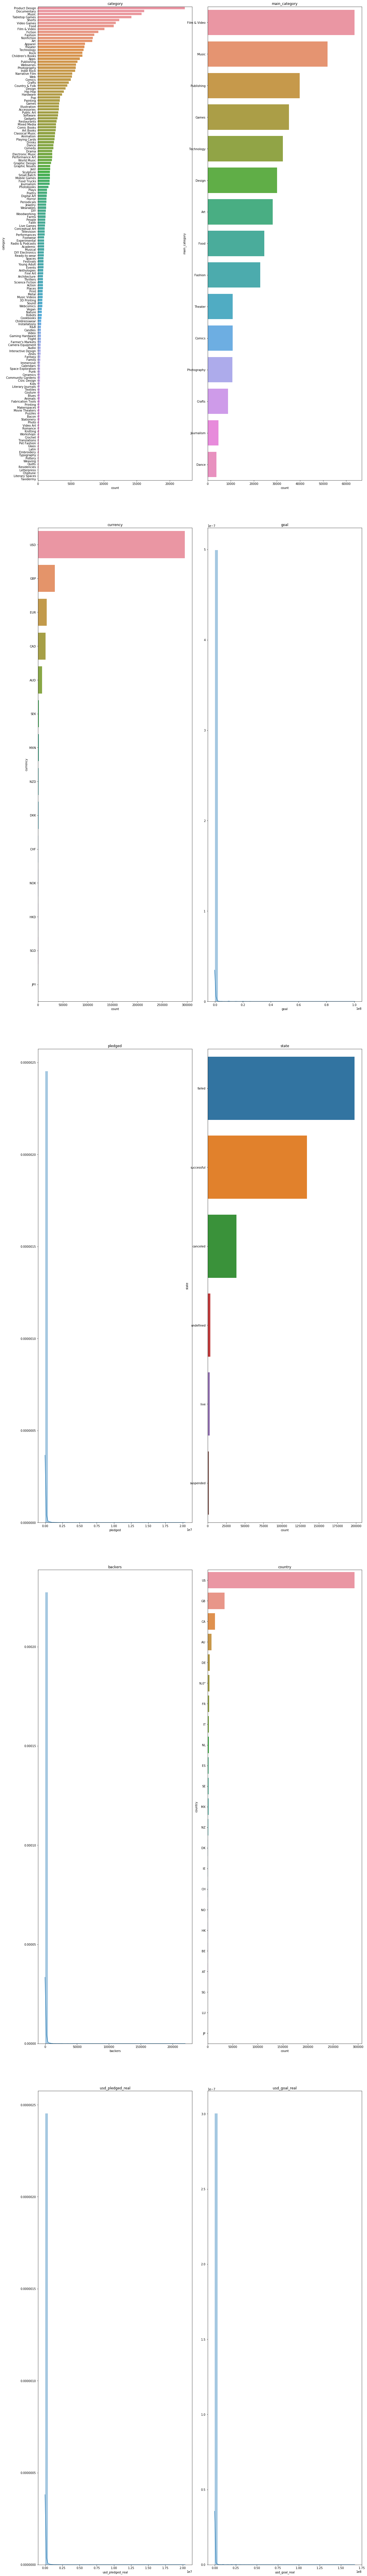

In [206]:
def plot_dists(dataset, ncols=2, ignore=[]):
  data = dataset.copy()
  data = data.dropna(axis=1)
  data = data.drop(columns=ignore)
  
  fig = plt.figure(figsize=(20, 20))
  fig.subplots_adjust(left=None, bottom=None, right=None, top=10, wspace=0.1, hspace=0.1)
  nrows = math.ceil(len(df.columns) / ncols)
  
  for idx, col in enumerate(data.columns):
    ax = fig.add_subplot(nrows, ncols, idx + 1)
    ax.set_title(col)
    
    if np.issubdtype(data[col].dtype, np.number):
      sns.distplot(data[col])
    elif data[col].dtype == np.object:
      sns.countplot(y=col, data=data, order = data[col].value_counts().index)
      
plot_dists(df, ignore=['ID', 'launched', 'deadline']) 

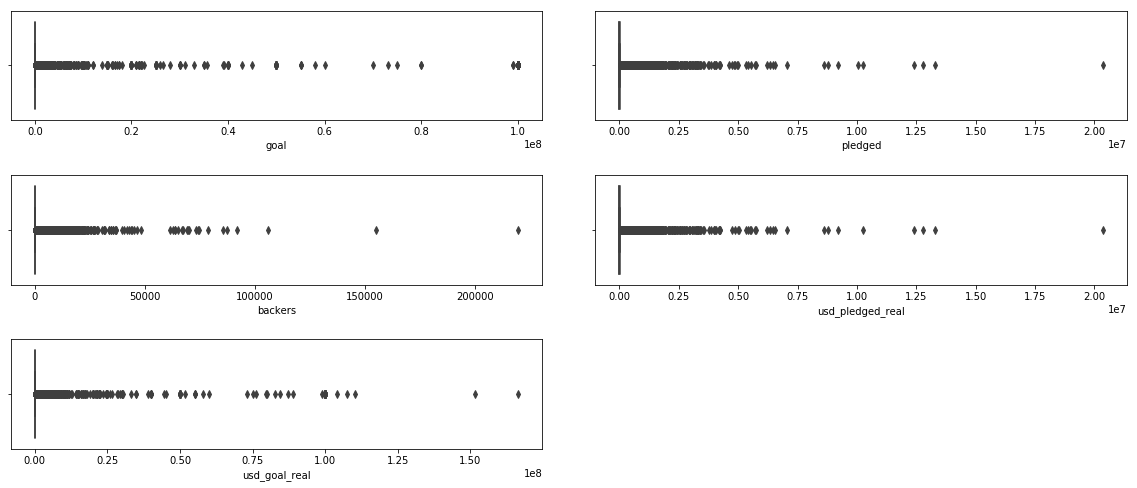

In [207]:
def plot_boxs(dataset, ncols=2, ignore=[]):
  data = dataset.copy()
  data = data.select_dtypes(include=[np.number])
  data = data.dropna(axis=1)
  data = data.drop(columns=ignore)
  
  fig = plt.figure(figsize=(20, 20))
  fig.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.1, hspace=0.5)
  nrows = math.ceil(len(df.columns) / ncols)
  
  for idx, col in enumerate(data.columns):
    ax = fig.add_subplot(nrows, ncols, idx + 1)
    sns.boxplot(x=data[col])
      
plot_boxs(df, ignore=['ID']) 

### Univariete Data Exploration

In [208]:
df.columns.tolist()

['ID',
 'name',
 'category',
 'main_category',
 'currency',
 'deadline',
 'goal',
 'launched',
 'pledged',
 'state',
 'backers',
 'country',
 'usd pledged',
 'usd_pledged_real',
 'usd_goal_real']

#### Feature State

In [209]:
df['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

State is a feature to predict. It contains 6 unique values. We can work with 2 unique values as successful and failed.

*   failed
*   canceled - considered same as failed
*   successful
*   live - cannot be identified, will be deleted
*   undefined - cannot be identified, will be deleted
*   suspended - dataset does not provide information why the project was suspended, consider as failed

As the state is categorical variable, we will encode it to numeric values using LabelEncoder.

In [0]:
states_to_drop = ['live', 'undefined']
df = df[~df['state'].isin(states_to_drop)]

df.loc[df['state'] == 'canceled', 'state'] = 'failed'
df.loc[df['state'] == 'suspended', 'state'] = 'failed'

#### Feature ID

ID does not have any impact on the final state of the project, therefore it will be deleted

In [0]:
df.drop(columns=['ID'], inplace=True)

#### Feature Name

Name can have impact on the project outcome, but it usually contains only a compact name or a very short description of the project. A detailed description that would be useful for natural language processing is not provided as a part of the dataset. The column will be deleted.

In [0]:
df.drop(columns=['name'], inplace=True)

#### Feature Category

This column describes category of a project it was proposed in. It is a more detailed than main_category column. As there are too many unique values in the dataset, we'll use only a parent of this category.

In [0]:
df.drop(columns=['category'], inplace=True)

#### Feature Main Category

A parent of category column. It describes in which category the project was published in. 

As this column contains categorical variables, an encoding using dummies is necessary for the model.

#### Feature Currency

As Kickstarter allows pledging to a project in any currency, this feature does not have any impact on the project state.

In [0]:
df.drop(columns=['currency'], inplace=True)

#### Feature Deadline

We expect that deadline of the project itself does not influence its outcome, but the feature will be use together with feature launched to create another feature - duration.

In [215]:
df['duration'] = (df['deadline'] - df['launched']).dt.days

df['duration'].describe()

count    372300.000000
mean         33.456441
std          66.448829
min           0.000000
25%          29.000000
50%          29.000000
75%          36.000000
max       16738.000000
Name: duration, dtype: float64

As can be seen from an output of describe method above, there are some extremes with value 16738. As we are exploring dataset from a single year, it's impossible that any project would last such long. All records with duration more than 2 years will be removed.

In [0]:
df = df.loc[df['duration'] <= 720]

Drop unused column deadline.

In [0]:
df.drop(columns=['deadline'], inplace=True)

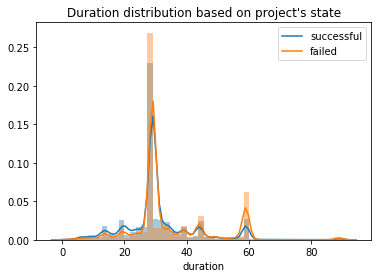

In [218]:
plt.figure()
plt.title('Duration distribution based on project\'s state')

sns.distplot(df.loc[df['state'] == 'successful']['duration'], kde_kws={"label": "successful"})
sns.distplot(df.loc[df['state'] == 'failed']['duration'], kde_kws={"label": "failed"})

As we can see above, projects' success does not seem to be influenced by duration column too much.

#### Feature Goal

This feature expresses goal of the project. Same column is used in usd_goal_real where the values are already converted to US dollars. To use this column, it would be necessary to convert the value by currency to one specified currency. It has already been done, therefore this column is useless for us.

In [0]:
df.drop(columns=['goal'], inplace=True)

#### Feature Launched

Launched feature was used to create an augmented value duration. Despite that, it will be still distributed into periods of year to be further investigated.

First we need to map column launched into launched_month. Then we split the values into year periods from Q1 to Q4 and save it into year_period column

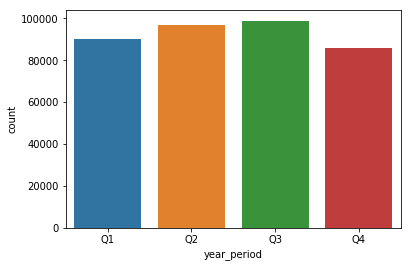

In [220]:
df['year_period'] = pd.cut(df['launched'].dt.month, bins=4, include_lowest=True, precision=0, labels=['Q1', 'Q2', 'Q3', 'Q4'])

sns.countplot(x='year_period', data=df);

df.drop(columns='launched', inplace=True)

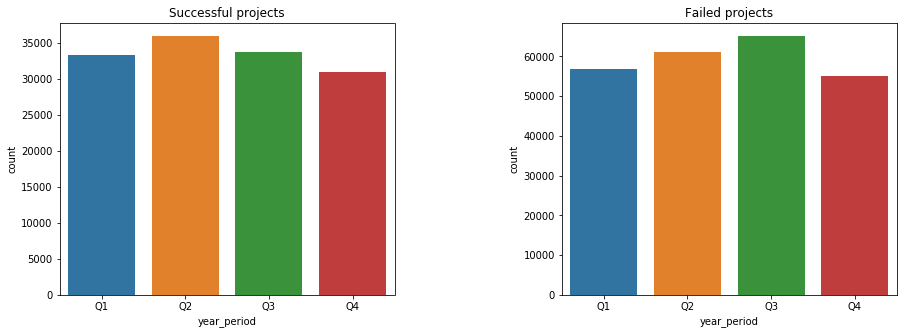

In [221]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Successful projects')
sns.countplot(x="year_period", data=df.loc[df['state'] == 'successful'])

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Failed projects')
sns.countplot(x="year_period", data=df.loc[df['state'] == 'failed'])

As the figure shows, successful projects are being launched in second quarter of the year, failed projects are being mostly launched in the third quarter

#### Feature Pledged

Same case as goal.

In [0]:
df.drop(columns=['pledged'], inplace=True)

#### Feature Backers

Backers express an amount of people that pledged some amount to the project. It's expected that more the project is successful, more backers there will be. It's highly unexpected that a project would be successful with less than 5 backers. Possibly in case the goal amount is low.

In [223]:
df.loc[df['state'] == 'successful']['backers'].describe()

count    133956.000000
mean        263.921362
std        1504.580142
min           0.000000
25%          33.000000
50%          71.000000
75%         167.000000
max      219382.000000
Name: backers, dtype: float64

We can see that there are extreme values in the backers feature. Maximum is way too big with respect to other values. For purpose of plotting the distribution, we can cut such values.

Let's first have a look what kind of project has got so many backers.

In [224]:
df.loc[(df['state'] == 'successful') & (df['backers'] == df['backers'].max())]

main_category       state  backers  ... usd_goal_real  duration  year_period
187652         Games  successful   219382  ...       10000.0        30           Q1

[1 rows x 9 columns]

Exploding Kittens! Famous desktop games that raised over US8.7 millions

75% of all values fit into 167, so for sake of simplicity and to achieve better visibility, we'll trim values over 1000 that can be considers as outliers.

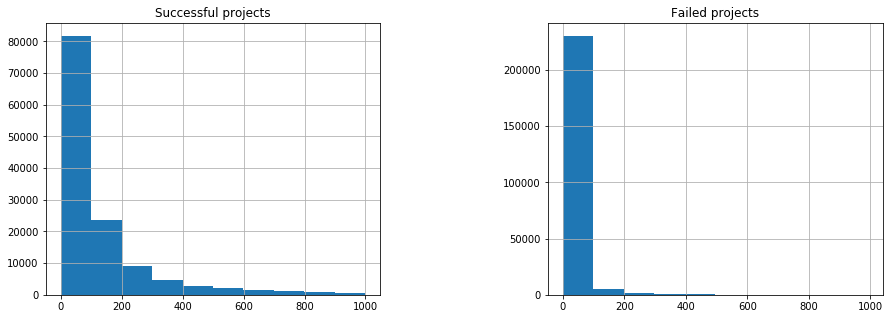

In [225]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Successful projects')
df.loc[(df['state'] == 'successful') & (df['backers'] < 1000), 'backers'].hist()

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Failed projects')
df.loc[(df['state'] == 'failed') & (df['backers'] < 1000), 'backers'].hist()

Most of successful projects have less than 500 backers. As expected, most of failed projects have less than 200 backers.

#### Feature Usd Pledged

This column is same as usd_pledged_real, let's delete it.

In [0]:
df.drop(columns=['usd pledged'], inplace=True)

#### Feature Usd Pledged Real

USD value of total amount pledged by backers. It is expected that pledged amount will have similar distribution to backers.

#### Feature Country

As the figure of values distribution in the beginning has shown, most of projects are funded in US. We can check if project's country has any relation to it's state.

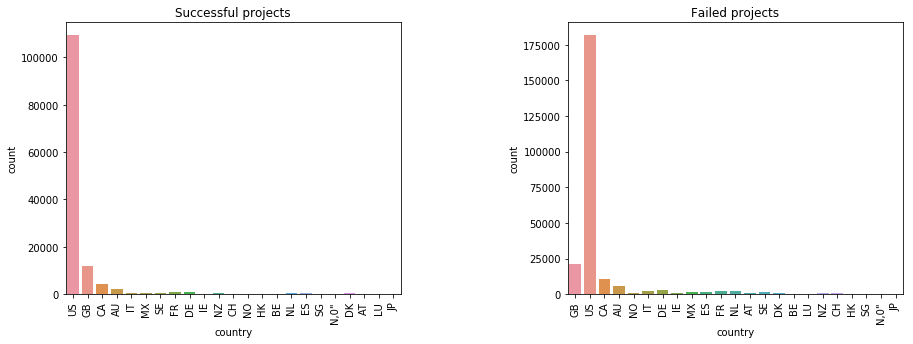

In [227]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Successful projects')
plt.xticks(rotation=90)
sns.countplot(x='country', data=df.loc[df['state'] == 'successful'])

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Failed projects')
plt.xticks(rotation=90)
sns.countplot(x='country', data=df.loc[df['state'] == 'failed'])


As the figure depicts, country does not have any impact on final state. Using country in model would increase number of categorical variables without any further significance. Feature country can be deleted then.

In [0]:
df.drop(columns=['country'], inplace=True)

#### Feature USD Goal Real

An amount required by project owners to be crowdfunded. An expectation is that higher the number will be, less successful the project will be.

We can visualize that with respect to main_category.

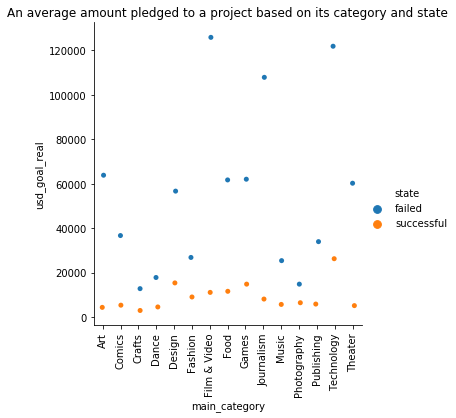

In [229]:
df_categories = df.copy()
df_categories = df_categories.groupby(['state', 'main_category'])['usd_goal_real'].mean().reset_index()

g = sns.catplot(x='main_category', y='usd_goal_real', hue='state', data=df_categories);
g.set_xticklabels(rotation=90);
plt.title('An average amount pledged to a project based on its category and state');

As expected, an average goal to be pledged is much lower for successful projects than for failed project. The issue is that as long as the project isn't necessarily awesome, backers tend to pledge money to project that has lower goal and therefore they have a higher chance to get a final product.

### Bivariete Data Exploration

In univariete feature analysis, every feature has been analysed separately. In bivariete data analysis, we explore all variables with respect to others. Data will be further distinguished by it's project state.

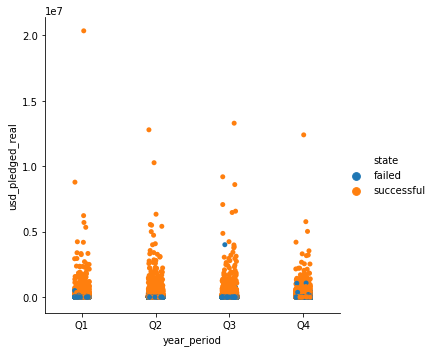

In [230]:
sns.catplot(x='year_period', y='usd_pledged_real', hue='state', data=df);

Without any surprise, more the project earns, more successful it is. Period of the year does not have any impact.

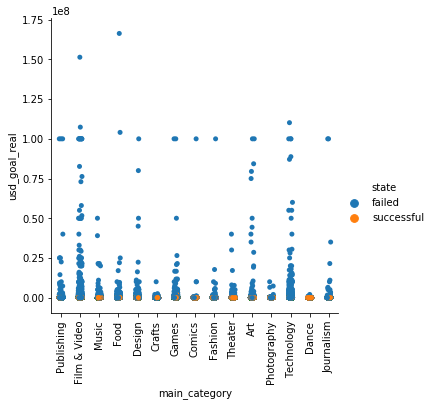

In [231]:
sns.catplot(x='main_category', y='usd_goal_real', hue='state', data=df);
plt.xticks(rotation=90);

The figure above depicts a relation between categories and their goals with respect to project's state. As can be seen on the graph, most of failed projects is asking for way too much money which results in their failure.

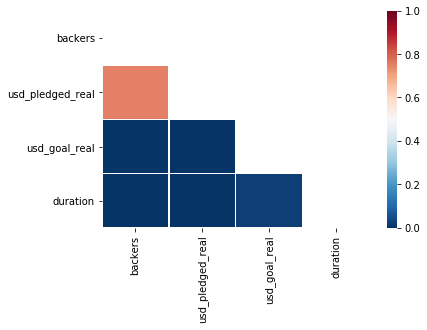

In [232]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), linewidths=.2,  cmap=sns.color_palette("RdBu_r", 100), mask=mask, xticklabels=True, yticklabels=True);

We can see in the correlation that most of the data are at least a little correlated to predicted value state.

There's a strong correlation between backers and pledged amount, but that makes sense because more money is raised, more backers there needs to be.

### Feature Encoding

In [0]:
state_label_encoder = LabelEncoder()

df['state'] = state_label_encoder.fit_transform(df['state'].values)

In [0]:
df = pd.get_dummies(df, prefix='main_category', columns=['main_category'])

In [0]:
df = pd.get_dummies(df, prefix='year_period', columns=['year_period'])

### Feature Augmentation

We created two additional columns:

*   duration
*   year_period

### Feature Reduction

Features were reduced manually with respect to visualized data. PCA, SVD or any other feature reduction method is not necessary then.

### Feature Scaling

In [0]:
scaler = MinMaxScaler()

scaled_cols = ['backers', 'usd_pledged_real', 'usd_goal_real']
df[scaled_cols] = scaler.fit_transform(df[scaled_cols]);

## Classification

For purpose of classification, columns _backers_ and _usd_pledged_real_ need to be deleted because those are unknown data before the project is published.

In [0]:
df.drop(columns=['backers', 'usd_pledged_real'], inplace=True)

### Splitting Dataset into Training/Test Set

In [0]:
cols = df.columns.values.tolist()

colsX = cols.copy()
colsX.remove('state')

x = df[colsX]
y = df['state']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [239]:
x_train.head()

usd_goal_real  duration  ...  year_period_Q3  year_period_Q4
183524   4.207701e-05        29  ...               0               1
337262   3.005499e-05        32  ...               0               0
377792   1.201601e-07        19  ...               1               0
340272   1.081981e-04        59  ...               0               0
238667   1.803297e-05        29  ...               0               0

[5 rows x 21 columns]

In [240]:
df.shape

(372293, 22)

We ended up with 25 columns from original 12. Considering the fact that it includes one-hot encoded categorical features, it is a significant progress.

In [0]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
  y_pred = model.predict(x_test)

  print("Accuracy in percentage: ", metrics.accuracy_score(y_test, y_pred) * 100)

  cv_pred = cross_val_predict(model, x_train, y_train, cv=5, n_jobs=-1)
  print("Cross Validation accuracy in percentage: ", metrics.accuracy_score(y_train, cv_pred) * 100)

### Random Forest Classifier

In [242]:
rfcl=RandomForestClassifier(n_estimators=100)

rfcl.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [243]:
evaluate_model(rfcl, x_train, y_train, x_test, y_test)

Accuracy in percentage:  64.49052498690556


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Cross Validation accuracy in percentage:  64.34188171934701


#### Feature Importance

As the output suggest, the most important features to distinguish between successful and failed projects are  usd_goal_real and duration.

According to the analysis performed earlier, such outcome was highly expected because  expected goal is a highly significant feature differing between successful and failed projects.

In [244]:
pd.Series(rfcl.feature_importances_,index=x_test.columns.values).sort_values(ascending=False)

usd_goal_real                 0.636104
duration                      0.261194
main_category_Music           0.016088
main_category_Theater         0.013041
main_category_Technology      0.011116
main_category_Comics          0.007703
main_category_Fashion         0.007126
main_category_Dance           0.005137
main_category_Food            0.004546
main_category_Film & Video    0.004009
main_category_Crafts          0.003787
main_category_Publishing      0.003610
year_period_Q3                0.003299
year_period_Q2                0.003187
year_period_Q1                0.003160
year_period_Q4                0.003084
main_category_Games           0.003066
main_category_Design          0.002849
main_category_Photography     0.002695
main_category_Journalism      0.002678
main_category_Art             0.002519
dtype: float64

### Logistic Regression

In [245]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [246]:
evaluate_model(logreg, x_train, y_train, x_test, y_test)

Accuracy in percentage:  65.72207523603593
Cross Validation accuracy in percentage:  65.80981352028311


### Gradient Boosted Tree

In [0]:
gbt = GradientBoostingClassifier(n_estimators = 100)
gbt = gbt.fit(x_train, y_train)

In [248]:
evaluate_model(gbt, x_train, y_train, x_test, y_test)

Accuracy in percentage:  67.877623927262
Cross Validation accuracy in percentage:  67.96168335381454


## Results Evaluation

We chose 3 classifiers while trying to predict whether the project will be successful. Starting with very popular Random Forest Classifier, then trying simpler Logistic Regression model and finally Gradient Boosted Tree.

There's no need to try another models as we already achieved 99% accuracy on the test set and even using cross validation.

As could be seen in _Feature Importance_ section, the data analysis prepared the data in a way that there are 4 most significant features (**backers, usd_pledged_real, usd_goal_real, duration**).

The result respects hypotheses proposed while analysing the data. Expectations were that successful project will have a high number of backers and a high amount pledged.

---


| Classifier | Test Set Accuracy  | Cross Validation Accuracy |
|--------|---------|--------------|
| Random Forest Classifier | 64.55 | 64.30 |
| Logistic Regression | 65.72  | 65.80  |
| Gradient Boosting Tree | 67.88 | 67.96 |


# Conclusion

This notebook performed an analysis of Kickstarter dataset provided by Kaggle. 

First, Exploratory Data Analysis was made, including univariete and bivariete feature analysis, data visualisation, cleaning, preprocessing, scaling and encoding.

Furthermore, it was decided to use 3 types of classifiers that achieved very high accuracy, in two cases exceeding 67 percent. 

After verification via cross validation, we can be sure that the model is not overfitted.

To sum up, similar projects on Kaggle analysing Kickstarter projects dataset also achieved 67 percent. Considering a fact that provided dataset was missing proper description to further describe the project itself, accuracy of 67 percent based only on categories is very good.

# Related Work

> https://www.kaggle.com/gagejustins/kickstarter-analysis-and-prediction

> https://github.com/mkucz95/kickstarter_data